### Project description
In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

source: Kaggle

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# Import English using en_core_web_sm.load()
import spacy
import en_core_web_sm
import html
import re
# Import matplotlib and wordcloud 
import matplotlib.pyplot as plt
import wordcloud
from spacy import displacy

In [2]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
nlp = en_core_web_sm.load()

In [4]:
twits_train = pd.read_csv('./drive/MyDrive/Colab Notebooks/deep-learning/train.csv')
twits_test = pd.read_csv('./drive/MyDrive/Colab Notebooks/deep-learning/test.csv')

In [5]:
twits_train.sample(5)


,id,keyword,location,text,target
6047,8643,sinkhole,NaN,MRW when a sinkhole opens up beneath my friend...,1
5578,7959,razed,NaN,Former Freedom Surf/Spa Razed to Make Way for ...,0
658,952,blaze,NaN,What Dems do. Blaze covered months ago.Chicago...,0
1031,1497,body%20bags,NaN,Attention all RCHS football players there will...,0
3152,4526,emergency,Adelaide,Myanmar floods: Childfund https://t.co/pQHQ4Jn...,1


In [6]:
twits_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Missing values

In [7]:
def missing_values(data):
    return pd.concat([data.isna().sum(), 
        np.round(data.isna().sum()*100/data.shape[0], 2)], 
        axis=1).rename({0:'count_missing', 1:'%_missing'}, axis=1)

In [8]:
#data.isnull().sum()*100/data.shape[0]
missing_values(twits_train)

,count_missing,%_missing
id,0,0.00
keyword,61,0.80
location,2533,33.27
text,0,0.00
target,0,0.00


### Count keywords in texts

In [9]:
print('Keyworks')
len(twits_train.keyword.unique())

Keyworks


222

In [10]:
keywords = twits_train.keyword.value_counts(ascending=False)
keywords[0:10]

fatalities     45
armageddon     42
deluge         42
body%20bags    41
sinking        41
damage         41
harm           41
evacuate       40
twister        40
collided       40
Name: keyword, dtype: int64

### Class distribution

In [11]:
def print_target(data:pd.DataFrame):
    return pd.concat({'% of values': (data['target'].value_counts() * 100 / data['target'].shape[0]), 
           'value_counts': data['target'].value_counts()}, axis=1)


In [12]:
print_target(twits_train)

,% of values,value_counts
0,57.034021,4342
1,42.965979,3271


In [13]:
textos = twits_train[twits_train['keyword'].notna()].iloc[25:30, [1,3]]
for t in textos.values:
    print(t)

['ablaze'
 'TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE OR TAMBO INTL. CARGO SECTION. http://t.co/8kscqKfKkF']
['ablaze'
 'Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @\x89Û_ https://t.co/cYoMPZ1A0Z']
['ablaze'
 "They sky was ablaze tonight in Los Angeles. I'm expecting IG and FB to be filled with sunset shots if I know my peeps!!"]
['ablaze'
 'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd']
['ablaze'
 'Revel in yours wmv videos by means of mac farewell ablaze wmv en route to dvd: GtxRWm']


### Train, test split

In [14]:
train, val = train_test_split(twits_train, test_size=0.2, random_state=42)


In [15]:
train.head(5)

,id,keyword,location,text,target
4996,7128,military,Texas,Courageous and honest analysis of need to use ...,1
3263,4688,engulfed,NaN,@ZachZaidman @670TheScore wld b a shame if tha...,0
4907,6984,massacre,Cottonwood Arizona,Tell @BarackObama to rescind medals of 'honor'...,1
2855,4103,drought,"Spokane, WA",Worried about how the CA drought might affect ...,1
4716,6706,lava,"Medan,Indonesia",@YoungHeroesID Lava Blast &amp; Power Red #Pan...,0


In [16]:
print_target(train)

,% of values,value_counts
0,56.945813,3468
1,43.054187,2622


### Cleaning

In [17]:
def removeurl(raw_text):
    clean_text = re.sub(r'https?://[\w\./]+\s*', '', raw_text, flags=re.MULTILINE)
    return clean_text
removeurl('Test text: Rene Ablaze &amp; Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  https://t.co/7MLMsUzV1Z somenthing https://t.co/7MLMsUzV1Z' )

'Test text: Rene Ablaze &amp; Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  somenthing '

In [18]:
def remove_coma(raw_text):
    '''
    Remove comas from numbers in raw_text. For ex. For a number like 13,000 it will be converted to 13000
    '''
    clean_text = raw_text
    matches = re.findall('\d+[,]\d*', raw_text)#pattern to identify numbers with comas
    for match in matches:
        new_text = re.sub(r'[,.]+', '', match, flags=re.MULTILINE)
        clean_text = re.sub(match, new_text, clean_text)
    return clean_text

In [19]:
def isolate_number(raw_text):
    '''
    Put spaces before and after a number.  For example 236.00end will be 233.00 end
    To isolate, first it finds the pattern and creates a group of words.  For ex. (236.00, end)
    '''
    clean_text = raw_text
    #pattern (\d+[.]+\d*)([A-Za-z]+) identifes numbers attached to letters and separate them in groups.
    matches = re.findall('(\d+[.]+\d*)([A-Za-z]+)', raw_text)
    for match in matches:
        #print(type(match),match)
        unsplit_match= ''.join(match)
        new_text = ' '.join(match)
        clean_text = re.sub(unsplit_match, new_text, clean_text)
    return clean_text

In [20]:
text = "Test text: M1.94 [01:04 UTC]?5km S of Volcano Hawaii 256.end 96.39opi 2.4region"
isolate_number(text)

'Test text: M1.94 [01:04 UTC]?5km S of Volcano Hawaii 256. end 96.39 opi 2.4 region'

#### Preprocess the train set

In [22]:
def preprocess(df)->pd.DataFrame:
    '''
    Formats the twits in order to remove urls, unescape chars, remove non alphanumerique words, removing comas,..
    returns 
        data: a dataFrame with the a column containing the cleaned texts
    '''
    #Check if the dataframe contains a target column
    cols = ['id', 'text', 'target'] if 'target' in df.columns else ['id', 'text']

    data = df.loc[:, cols].copy()

    data['text_clean'] = data['text'].apply(lambda x: removeurl(x))
    data['text_clean'] = data['text_clean'].apply(lambda x: html.unescape(x))
    data['text_clean'] = data['text_clean'].str.replace(r"[^A-Za-z0-9',.]+", " ")#replace non alphanum , dots and commas with space
    data['text_clean'] = data['text_clean'].apply(lambda x: remove_coma(x))
    data['text_clean'] = data['text_clean'].apply(lambda x: isolate_number(x))
    data['text_clean'] = data['text_clean'].fillna('').apply(lambda x: x.lower())
    #data['text_clean'] = data['text_clean'].apply(lambda x: [w.strip() for w in x if w!=''])
    data['text_clean'] = data['text_clean'].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
    data['text_clean'] = data['text_clean'].str.replace(r"\s+", " ")
    return data
#replace double spaces with only one


In [23]:
train = preprocess(train)
#train.head(3)

In [24]:
pd.options.display.max_colwidth = 110
#data.style.set_properties(**{'text-align': 'left'})
train[['text','text_clean']][20:25]

,text,text_clean
3703,My biggest fear is disappointing the people who believe in me,my biggest fear is disappointing the people who believe in me
2298,Just had my first counter on a league game against another Orianna I happened to demolish her xD. I totall...,just had my first counter on a league game against another orianna i happened to demolish her xd i totally...
746,they say bad things happen for a reason\nbut no wise words gonna stop te bleeding,they say bad things happen for a reason but no wise words gonna stop te bleeding
5926,@CortezEra I dead ass screamed when we signed him I couldn't fucking believe it,cortezera i dead ass screamed when we signed him i couldnt fucking believe it
7571,@Caitsroberts see U the night wee bArra to get absolutely wrecked ????,caitsroberts see u the night wee barra to get absolutely wrecked


#### Preprocess the validation set

In [25]:
val = preprocess(val)

#### Tokenize the train and validation sets

In [26]:
import unicodedata
#spacy.explain('conj')
#displacy.render(doc,style='dep', jupyter=True,)

In [27]:
#!python -m spacy download en -q
# Import english stop words
from spacy.lang.en.stop_words import STOP_WORDS

# Print stop words
print(STOP_WORDS)

{'she', 'meanwhile', 'ten', 'under', 'there', 'whole', 'towards', 'various', 'six', 'every', 'beforehand', 'are', 'ourselves', 'therefore', 'besides', 'thereafter', 'everything', 'hereafter', 'regarding', 'few', 'how', 'ours', 'a', 'through', 'among', 'can', 'show', 'out', 'these', 'empty', 'those', 'each', 'yours', 'also', 'whence', 'down', 'using', 'other', 'say', 'when', 'himself', 'beyond', 'so', 'at', 'upon', 'perhaps', 'them', 'whereas', 'may', 'became', 'somehow', 'thereby', 'you', 'whatever', 'any', 'move', 'whereupon', 'however', 'none', 'would', 'what', 'anywhere', 'they', 'side', 'cannot', 'be', 'nevertheless', "n't", 'our', 'own', '‘s', 'if', 'part', "'ve", 'someone', 'should', 'which', 'below', 'well', 'used', 'almost', 'latterly', 'twenty', 'already', 'seeming', 'sixty', 'somewhere', 'since', 'until', 'unless', 'thus', 'nothing', 'elsewhere', 'eight', 'that', 'nor', 'do', 'latter', 'fifty', 'after', 'moreover', 'top', 'make', 'who', 'name', 'wherever', 'otherwise', 'again

In [28]:
def tokenize_data(df:pd.DataFrame)->pd.DataFrame:
    data = df.copy()
    # nlp tokenization
    data['text_clean'] = data['text_clean'].apply(lambda x: nlp(x))
    # keep lemmatized words that aren't stop words or punctuation
    data['text_ready'] = data['text_clean'].apply(
        lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS and token.pos_!= 'PUNCT'])#x is a doc
    data['text_ready'] = data['text_ready'].apply(lambda x: ' '.join(x))
    return data

In [29]:
train = tokenize_data(train)
val = tokenize_data(val)

In [30]:
train[['text','text_clean','text_ready']].sample(5)

,text,text_clean,text_ready
6266,@Jenniferarri_ comeeeee! ...but why is it bout to storm tho,"( , jenniferarri, comeeeee, but, why, is, it, bout, to, storm, tho)",jenniferarri comeeeee bout storm tho
49,First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single n...,"(first, night, with, retainers, in, its, quite, weird, better, get, used, to, it, i, have, to, wear, them,...",night retainer weird better wear single night year
3700,The meaning I picked the one that changed my life: overcome fear behold wonder.\n\nTCC catch the light... ...,"(the, meaning, i, picked, the, one, that, changed, my, life, overcome, fear, behold, wonder, tcc, catch, t...",meaning pick change life overcome fear behold wonder tcc catch light endless
387,Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel http://t.co/KkbXIBlAH7,"(mourning, notices, for, stabbing, arson, victims, stir, politics, of, grief, in, israel)",mourning notice stab arson victim stir politic grief israel
1868,yhngsjlg just tweeted about their secret crush:http://t.co/IoqM5bm1Dg,"(yhngsjlg, just, tweeted, about, their, secret, crush)",yhngsjlg tweet secret crush


In [31]:
exemple = print(train.loc[5796, ['text', 'text_clean', 'text_ready']])
exemple

text                     @RyleeDowns02 @nevaehburton33 if I don't get my money by tomorrow rioting ??
text_clean    ( , ryleedowns02, nevaehburton33, if, i, do, nt, get, my, money, by, tomorrow, rioting)
text_ready                                                  nevaehburton33 not money tomorrow rioting
Name: 5796, dtype: object


In [32]:
print('Example of nlp text produced by nlp()')
text_nlp = train['text_clean'] 
for token in text_nlp[5796]:
    print(token.lemma_, token.pos_)

Example of nlp text produced by nlp()
  SPACE
ryleedowns02 PUNCT
nevaehburton33 PROPN
if SCONJ
i PRON
do AUX
not PART
get AUX
-PRON- DET
money NOUN
by ADP
tomorrow NOUN
rioting NOUN


In [33]:
# Install wordcloud if necessary 
#!pip install wordcloud -q

### Visualize world clouds

In [34]:
def join_twits(data, target)-> str:
    '''
    Concatenate the words of all twits
    data: DataFrame that must contain the feature "text_ready"
    target: Either 1 or 0.  Indicates if a twit is disaster (1) or not (0)
    '''
    twit_list = data[data['target'] == target]['text_ready'].values
    return ' '.join(twit_list)

In [35]:
def draw_cloud(text):
    wd = wordcloud.WordCloud(width=800, 
                    height=400,)
    cloud = wd.generate(text)

    # Show word cloud with matplotlib 
    plt.figure(figsize=(10, 8))
    plt.imshow(cloud)

    # Remove trailing logs 
    plt.show()

Words in disaster twits


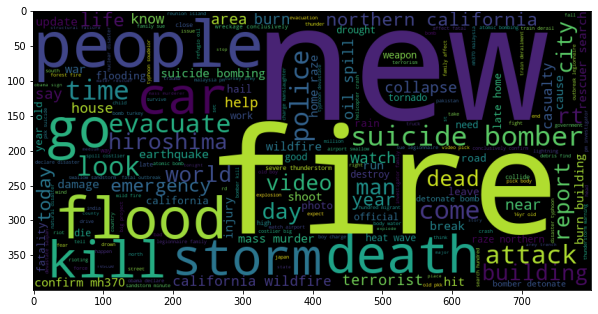

In [36]:
print('Words in disaster twits')
draw_cloud(join_twits(train, 1))

Words in non-disaster twit


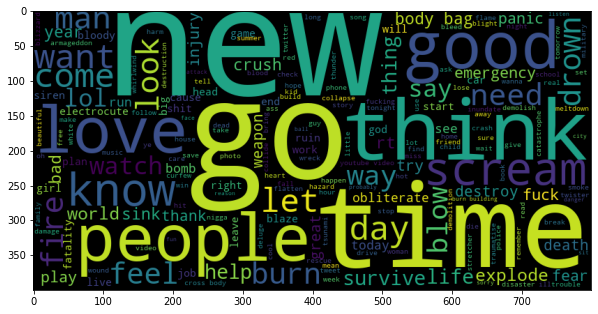

In [37]:
print('Words in non-disaster twit')
draw_cloud(join_twits(train, 0))

#### Word count

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TruncatedSVD from sklearn
#from sklearn.decomposition import TruncatedSVD

In [39]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
X = vectorizer.fit_transform(train['text_ready'])
dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
dense.shape

(6090, 12776)

In [41]:
it = iter(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])))
for i in range(10):
    print(next(it))

00
0000
00pm
01
02
02pm
03
030
033
034


#### Vocabulary

In [42]:
len(vectorizer.vocabulary_)

12776

In [43]:
data_idf = pd.DataFrame(dense, columns=[x for x in vectorizer.get_feature_names()])
#data_idf

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
word_count = list()
words = data_idf.columns.to_list()
word_count = [(data_idf[c] !=0.0).sum() for c in data_idf.columns]

In [45]:
data_wcounts = pd.DataFrame(zip(words,word_count), columns=['word', 'count'])


In [46]:
#data_idf['token'] = data_idf.index
data_wcounts[data_wcounts['count']>1].sort_values(by='count', ascending=False)[:10]

,word,count
6777,like,298
7899,new,173
8611,people,166
7910,news,160
12116,video,142
12660,year,133
1980,burn,132
2648,come,129
6419,kill,128
1734,bomb,128


In [47]:
import plotly.express as px

# Create bar chart
fig = px.bar(data_wcounts.sort_values(by='count', ascending=False)[:15], x="word", y='count')

# Render chart
fig.show()

In [48]:
from collections import Counter
word_freq = Counter(vectorizer.vocabulary_)
word_freq.items

<function Counter.items>

In [49]:
#word_freq

In [50]:
#tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token='<UNK>')

### Transform text to sequences

In [51]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, oov_token='unk')
tokenizer.fit_on_texts(train['text_ready'])
train["text_encoded"] = tokenizer.texts_to_sequences(train['text_ready'])
train['len_text'] = train["text_encoded"].apply(lambda x: len(x))
train = train[train["len_text"]!=0]

In [52]:
train.head()

,id,text,target,text_clean,text_ready,text_encoded,len_text
4996,7128,Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused ...,1,"(courageous, and, honest, analysis, of, need, to, use, atomic, bomb, in, 1945, hiroshima70, japanese, mili...",courageous honest analysis need use atomic bomb 1945 hiroshima70 japanese military refuse surrender,"[4793, 3198, 2023, 64, 241, 176, 17, 1713, 3199, 968, 214, 1487, 3200]",13
3263,4688,@ZachZaidman @670TheScore wld b a shame if that golf cart became engulfed in flames. #boycottBears,0,"( , zachzaidman, 670thescore, wld, b, a, shame, if, that, golf, cart, became, engulfed, in, flames, boycot...",zachzaidman 670thescore wld b shame golf cart engulf flame boycottbear,"[4794, 4795, 4796, 513, 1219, 2024, 2490, 363, 128, 4797]",10
4907,6984,Tell @BarackObama to rescind medals of 'honor' given to US soldiers at the Massacre of Wounded Knee. SIGN ...,1,"(tell, barackobama, to, rescind, medals, of, honor, given, to, us, soldiers, at, the, massacre, of, wounde...",tell barackobama rescind medal honor give soldier massacre wound knee sign rt,"[188, 2491, 4798, 3201, 3202, 285, 969, 330, 98, 1365, 215, 54]",12
2855,4103,Worried about how the CA drought might affect you? Extreme Weather: Does it Dampen Our Economy? http://t.c...,1,"(worried, about, how, the, ca, drought, might, affect, you, extreme, weather, does, it, dampen, our, economy)",worried drought affect extreme weather dampen economy,"[3203, 315, 316, 1220, 232, 4799, 1125]",7
4716,6706,@YoungHeroesID Lava Blast &amp; Power Red #PantherAttack @JamilAzzaini @alifaditha,0,"( , youngheroesid, lava, blast, power, red, pantherattack, jamilazzaini, alifaditha)",youngheroesid lava blast power red pantherattack jamilazzaini alifaditha,"[1714, 387, 347, 414, 317, 1715, 4800, 4801]",8


#### Transform the val set

In [53]:
# We do the same on the test set, except we do not fit the tokenizer this time
val["text_encoded"] = tokenizer.texts_to_sequences(val['text_ready'])
val["len_text"] = val["text_encoded"].apply(lambda x: len(x))
val = val[val["len_text"]!=0]

In [54]:
val.head()

,id,text,target,text_clean,text_ready,text_encoded,len_text
2644,3796,So you have a new weapon that can cause un-imaginable destruction.,1,"(so, you, have, a, new, weapon, that, can, cause, un, imaginable, destruction)",new weapon cause un imaginable destruction,"[8, 76, 49, 1302, 1, 319]",6
2227,3185,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mis...,0,"(the, f, ing, things, i, do, for, gishwhes, just, got, soaked, in, a, deluge, going, for, pads, and, tampo...",f ing thing gishwhe get soak deluge go pad tampon thx mishacollin,"[823, 1, 106, 1, 9, 2652, 169, 7, 1, 1, 1897, 1]",12
5448,7769,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... htt...,1,"(dt, georgegalloway, rt, galloway4mayor, the, col, police, can, catch, a, pickpocket, in, liverpool, stree)",dt georgegalloway rt galloway4mayor col police catch pickpocket liverpool stree,"[1, 1, 54, 1, 3275, 42, 443, 1, 1, 1]",10
132,191,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a grea...,0,"(aftershock, back, to, school, kick, off, was, great, i, want, to, thank, everyone, for, making, it, possi...",aftershock school kick great want thank make possible great night,"[595, 101, 882, 115, 44, 147, 240, 366, 115, 179]",10
6845,9810,in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3,0,"(in, response, to, trauma, children, of, addicts, develop, a, defensive, self, one, that, decreases, vulne...",response trauma child addict develop defensive self decrease vulnerability 3,"[1117, 295, 237, 1, 2713, 1, 314, 1, 1, 29]",10


#### Pad sequences

In [55]:
MAX_LEN = 50

In [56]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train.text_encoded, padding="post", maxlen = MAX_LEN)
train_pad.shape

(6090, 50)

In [57]:
val_pad = tf.keras.preprocessing.sequence.pad_sequences(val.text_encoded, padding="post", maxlen = MAX_LEN)
val_pad.shape

(1523, 50)

In [58]:
full_ds =  tf.data.Dataset.from_tensor_slices((train_pad, train.target))
full_val_ds = tf.data.Dataset.from_tensor_slices((val_pad, val.target))

In [59]:
train_data = full_ds.shuffle(len(full_ds)).batch(16)
val_data = full_val_ds.shuffle(len(full_val_ds)).batch(16)

In [60]:
val_data

<BatchDataset shapes: ((None, 50), (None,)), types: (tf.int32, tf.int64)>

In [61]:
train_data

<BatchDataset shapes: ((None, 50), (None,)), types: (tf.int32, tf.int64)>

In [62]:
 # Regardons un batch 
for twit, target in train_data.take(1):
  print(twit, target)

tf.Tensor(
[[2545  210  124  626  220  210  628 1899 1452 1411 2257 1900 2184    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  40  437  403  341  263    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  67   16  887  239  309  509   20    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   1   14    1    1  920    1  882 1878   46 1128 2097 1168    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  

In [63]:
tokenizer.num_words

5000

### Simple model: 1 Embedding, 2 dense layers

In [64]:
embed_size = 32
vocab_size = tokenizer.num_words+1
model = tf.keras.Sequential([
                  # Layer for word embedding,
                  tf.keras.layers.Embedding(vocab_size, embed_size),
                  #
                  GlobalAveragePooling1D(),
                  # Couche Dense classique 
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),
                  
                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")])


In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          160032    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 164,257
Trainable params: 164,257
Non-trainable params: 0
__________________________________________________

In [66]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [67]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs2")

In [68]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[tensorboard_callback])

Epoch 1/10
381/381 [==============================] - 3s 5ms/step - loss: 0.6395 - accuracy: 0.6278 - val_loss: 0.4862 - val_accuracy: 0.7873
Epoch 2/10
381/381 [==============================] - 2s 4ms/step - loss: 0.3975 - accuracy: 0.8314 - val_loss: 0.4422 - val_accuracy: 0.8024
Epoch 3/10
381/381 [==============================] - 2s 4ms/step - loss: 0.3171 - accuracy: 0.8719 - val_loss: 0.4722 - val_accuracy: 0.7899
Epoch 4/10
381/381 [==============================] - 2s 4ms/step - loss: 0.2714 - accuracy: 0.8916 - val_loss: 0.4816 - val_accuracy: 0.7965
Epoch 5/10
381/381 [==============================] - 2s 4ms/step - loss: 0.2342 - accuracy: 0.9066 - val_loss: 0.6758 - val_accuracy: 0.7026
Epoch 6/10
381/381 [==============================] - 2s 4ms/step - loss: 0.2132 - accuracy: 0.9166 - val_loss: 0.5876 - val_accuracy: 0.7695
Epoch 7/10
381/381 [==============================] - 2s 4ms/step - loss: 0.1752 - accuracy: 0.9327 - val_loss: 0.6274 - val_accuracy: 0.7623
Epoch 

The model is overfitting when it keeps learning.  The best parameters would be in epoch 2
> It's possible to add Dropout layers to regularize, stop learning at epoch 2, ...


In [69]:
embed_size = 32
vocab_size = tokenizer.num_words+1
model = tf.keras.Sequential([
                  # Layer for word embedding,
                  tf.keras.layers.Embedding(vocab_size, embed_size),
                  #
                  GlobalAveragePooling1D(),
                  # Couche Dense classique 
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),
                  
                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=2,
    callbacks=[tensorboard_callback])

Epoch 1/2
381/381 [==============================] - 3s 5ms/step - loss: 0.6358 - accuracy: 0.6264 - val_loss: 0.5106 - val_accuracy: 0.7518
Epoch 2/2
381/381 [==============================] - 2s 4ms/step - loss: 0.3911 - accuracy: 0.8348 - val_loss: 0.4648 - val_accuracy: 0.7938


### Generation submission file

#### Preproces, tokenize and transform to sequences

In [70]:

test = preprocess(twits_test)
test = tokenize_data(test)
test["text_encoded"] = tokenizer.texts_to_sequences(test['text_ready'])
test["len_text"] = test["text_encoded"].apply(lambda x: len(x))


Check if there are twits that couldn't be encoded

In [71]:
test[test["len_text"]==0]

,id,text,text_clean,text_ready,text_encoded,len_text
13,43,What if?!,"(what, if)",,[],0


Clean the one twit that cannot be encoded

In [72]:
test.loc[13, 'text_ready'] = 'unk' #token used to fill words not existing in the vacabulary
test["text_encoded"] = tokenizer.texts_to_sequences(test['text_ready'])
test["len_text"] = test["text_encoded"].apply(lambda x: len(x))
test[test["len_text"]==0]

,id,text,text_clean,text_ready,text_encoded,len_text


In [73]:
pad_test = tf.keras.preprocessing.sequence.pad_sequences(test.text_encoded, padding="post", maxlen = MAX_LEN)

#### Predict disaster and non-disaster twits 

In [74]:
test_data = tf.data.Dataset.from_tensor_slices(pad_test)
test_data

<TensorSliceDataset shapes: (50,), types: tf.int32>

In [75]:
y_pred=model.predict(test_data.batch(16))
y_pred=np.round(y_pred).astype(int).reshape(len(test))
y_pred

array([1, 1, 1, ..., 1, 1, 1])

#### Generate submission file

In [76]:
submission = pd.DataFrame({'id':test['id'], 'target':y_pred})
submission.to_csv('submission.csv', index=False)

In [77]:
submission.target.value_counts()

0    1814
1    1449
Name: target, dtype: int64

#### Example of predictions

In [78]:
test['prediction'] = y_pred

In [80]:
test.sample(5)

,id,text,text_clean,text_ready,text_encoded,len_text,prediction
2595,8641,@Statoilasa &amp; @TOTAL make significant discovery in the North Sea: Visualise the full potential on our ...,"( , statoilasa, total, make, significant, discovery, in, the, north, sea, visualise, the, full, potential,...",statoilasa total significant discovery north sea visualise potential seismic g,"[1, 630, 3798, 2362, 535, 731, 1, 1149, 431, 694]",10,1
1304,4290,Migrants drowning - we will be erecting monuments 100 years from now and shed tears for the most powerful ...,"(migrants, drowning, we, will, be, erecting, monuments, 100, years, from, now, and, shed, tears, for, the,...",migrant drown erect monument 100 year shed tear powerful nation greed let die,"[230, 66, 1, 1, 608, 14, 2577, 1107, 1400, 1793, 1, 62, 95]",13,0
1056,3458,Train derailed at Smithsonian Metro. Sidewalks outside L'Enfant mobbed to get on buses @wmata #nightmareco...,"(train, derailed, at, smithsonian, metro, sidewalks, outside, lenfant, mobbed, to, get, on, buses, wmata, ...",train derail smithsonian metro sidewalks outside lenfant mob bus wmata nightmarecommute,"[41, 102, 2919, 1284, 1, 645, 1, 1, 213, 1757, 1]",11,1
2985,9871,@TremendousTroye I'm so traumatised,"( , tremendoustroye, i, m, so, traumatised)",tremendoustroye be traumatise,"[1, 6, 356]",3,0
619,2018,American Weapons and Support Are Fueling a Bloody Air War in Yemen http://t.co/ZBLU4xXo44,"(american, weapons, and, support, are, fueling, a, bloody, air, war, in, yemen)",american weapon support fuel bloody air war yemen,"[623, 76, 492, 1104, 229, 239, 65, 3520]",8,1
